# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда. 



In [13]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    
    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    
    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3, 
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)
    
    return train_loader, val_loader, test_loader
    

In [14]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, 
                                                         transform_train=transform)

Files already downloaded and verified
Files already downloaded and verified


Посмотрим на изображения:

Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/connection.py", line 416, in _send_bytes
    self._send(header + buf)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


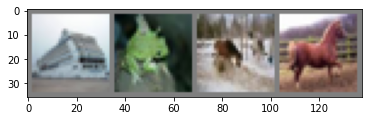

ship frog horse horse


In [15]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [16]:
n_classes = 10
n_channels = 32

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv2d(3, n_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_channels),
            nn.ReLU(),
            nn.Conv2d(n_channels, n_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_channels),
        )

        self.shortcut = nn.Conv2d(3, n_channels, kernel_size=1)
        self.poolling = nn.AvgPool2d(kernel_size=8)

        self.linear = nn.Linear(512, n_classes)

    def forward(self, x):
        shortcut = self.shortcut(x)
        x = self.block(x)
        x = x + shortcut
        x = nn.ReLU()(x)
        
        x = self.poolling(x)
        x = torch.flatten(x, start_dim=1)
        return self.linear(x)
        

In [17]:
net = BasicBlockNet()
net

BasicBlockNet(
  (block): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (poolling): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (linear): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [18]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [19]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps:0')
print(device)

mps:0


In [20]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [21]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    
    for data, target in loader:
        data = data.to(device)
        target = target.to(device)

        with torch.no_grad():
            logits = model(data)
            loss = nn.CrossEntropyLoss()(logits, target)
        loss_log.append(loss.item())
        
        acc = torch.mean((logits.argmax(dim=1) == target).to(torch.float32))
        acc_log.append(acc.item()) 
        
    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        logits = model(data)
        loss = nn.CrossEntropyLoss()(logits, target)
        loss.backward()
        optimizer.step()
        
        loss_log.append(loss.item())
        
        acc = torch.mean((logits.argmax(dim=1) == target).to(torch.float32))
        acc_log.append(acc.item()) 

    return np.mean(loss_log), np.mean(acc_log)

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.append(train_loss)
        train_acc_log.append(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {train_loss}, train acc: {train_acc}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [22]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.456367554241822, train acc: 0.48102474539545814
 val loss: 1.18896805986445, val acc: 0.5782136526513607

Epoch 1
 train loss: 1.1518090542753174, train acc: 0.5980265735490231
 val loss: 1.0941569602235834, val acc: 0.6216755319148937

Epoch 2
 train loss: 1.0371377784111817, train acc: 0.6394130321699697
 val loss: 1.066639392933947, val acc: 0.6277260638297872

Epoch 3
 train loss: 0.9803754016075971, train acc: 0.6587229041992202
 val loss: 1.0334040481993492, val acc: 0.6433510638297872

Epoch 4
 train loss: 0.946985999561533, train acc: 0.6708017759828725
 val loss: 1.008900463834722, val acc: 0.6491356382978724

Epoch 5
 train loss: 0.9217621738557624, train acc: 0.6802404348549503
 val loss: 0.9525623547269942, val acc: 0.6751551420130628

Epoch 6
 train loss: 0.8936642730911646, train acc: 0.6882345260170304
 val loss: 1.014182616801972, val acc: 0.6572695037151904

Epoch 7
 train loss: 0.8761659270012836, train acc: 0.6959225646538534
 val loss: 0.94922

Посчитайте точность на тестовой выборке:

In [23]:
test_loss, test_acc = test(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_acc}")

 test loss: 0.8858547913041085, test acc: 0.6930732484076433


Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

In [24]:
def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

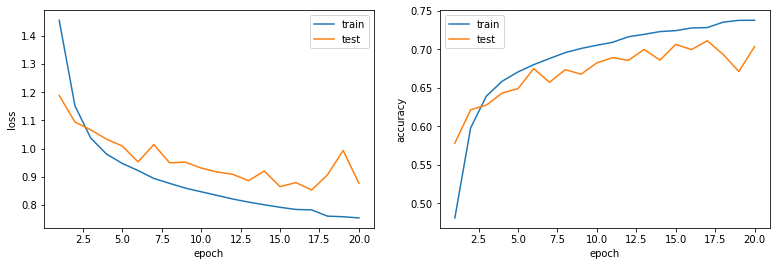

In [25]:
plot_losses(train_loss_log, val_loss_log, train_acc_log, val_acc_log)

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [26]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.467185878230623, train acc: 0.4779968660535934
 val loss: 1.299528160247397, val acc: 0.5408909574468085

Epoch 1
 train loss: 1.1514279029487038, train acc: 0.5977001176019909
 val loss: 1.1171479811059668, val acc: 0.6112367021276596

Epoch 2
 train loss: 1.0470144554727474, train acc: 0.6344631431961408
 val loss: 1.234742149647246, val acc: 0.5742242908224147

Epoch 3
 train loss: 0.9902935971725575, train acc: 0.6553726495946783
 val loss: 0.9651751657749744, val acc: 0.6690381206096487

Epoch 4
 train loss: 0.9482894176974811, train acc: 0.669283755627585
 val loss: 0.993927082609623, val acc: 0.652127659574468

Epoch 5
 train loss: 0.9150691471544437, train acc: 0.6828480021827181
 val loss: 0.9688534898960844, val acc: 0.6646276595744681

Epoch 6
 train loss: 0.8947461999857448, train acc: 0.6866879407622914
 val loss: 0.9228874764543898, val acc: 0.6856161348363187

Epoch 7
 train loss: 0.8829798511547842, train acc: 0.6934986288848263
 val loss: 0.89682

Посчитайте точность на тестовой выборке:

In [27]:
test_loss, test_acc = test(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_acc}")

 test loss: 0.8254122136125139, test acc: 0.7190485668789809


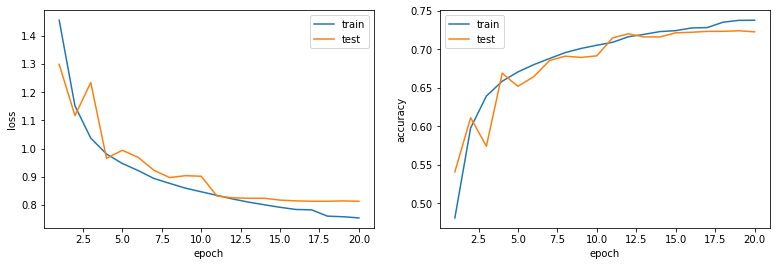

In [28]:
plot_losses(train_loss_log, val_loss_log, train_acc_log, val_acc_log)

**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [29]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.8587587790689695, train acc: 0.34674931444241314
 val loss: 1.6385332701054025, val acc: 0.4318484042553192

Epoch 1
 train loss: 1.5726039117607382, train acc: 0.44760789372149506
 val loss: 1.4885548601759242, val acc: 0.4782136525245423

Epoch 2
 train loss: 1.4449414927955084, train acc: 0.4922385088268538
 val loss: 1.4078952966852392, val acc: 0.5048980497299357

Epoch 3
 train loss: 1.3607721239382868, train acc: 0.5224887373460494
 val loss: 1.314697416285251, val acc: 0.5406693263256803

Epoch 4
 train loss: 1.299684361086467, train acc: 0.5453977867061957
 val loss: 1.2577457326523802, val acc: 0.5645833333756062

Epoch 5
 train loss: 1.2457342765666886, train acc: 0.5635324171735774
 val loss: 1.215220844745636, val acc: 0.5785017731341909

Epoch 6
 train loss: 1.2047153092389569, train acc: 0.5816711283253142
 val loss: 1.202215767414012, val acc: 0.5808289007937655

Epoch 7
 train loss: 1.1603482245745127, train acc: 0.5960433534338008
 val loss: 1.1

In [30]:
test_loss, test_acc = test(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_acc}")

 test loss: 0.9371563249332889, test acc: 0.6751592356687898


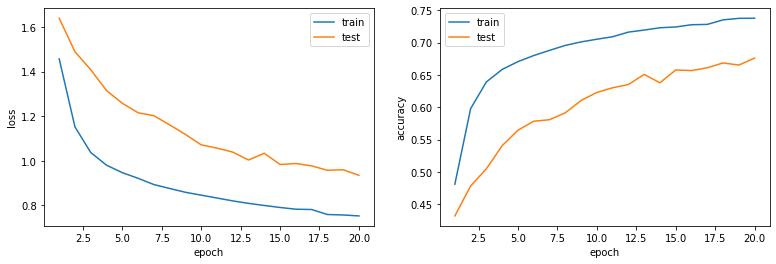

In [31]:
plot_losses(train_loss_log, val_loss_log, train_acc_log, val_acc_log)

**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

**StepLR**: каждые `step_size` умножает изначальный `lr` на `gamma`. Таким образом можно сделать плавное затухание градиента

In [32]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.480389561361107, train acc: 0.47059855709564097
 val loss: 1.281166548170942, val acc: 0.5546764184819891

Epoch 1
 train loss: 1.1504598614066786, train acc: 0.5984224014569898
 val loss: 1.0438638205223896, val acc: 0.6364804965384463

Epoch 2
 train loss: 1.0434822476106327, train acc: 0.6357608057245258
 val loss: 1.0146230405949532, val acc: 0.6466090425531915

Epoch 3
 train loss: 0.9871092266530833, train acc: 0.6554052951784849
 val loss: 1.0252554926466435, val acc: 0.6444813829787234

Epoch 4
 train loss: 0.9459372623746967, train acc: 0.6701896710413248
 val loss: 0.9795151226063992, val acc: 0.6545877659574468

Epoch 5
 train loss: 0.8597243561169348, train acc: 0.6993258684819098
 val loss: 0.9107566704141333, val acc: 0.6883643617021277

Epoch 6
 train loss: 0.8425154184728479, train acc: 0.7077157874429901
 val loss: 0.8955117410801826, val acc: 0.6926196808510638

Epoch 7
 train loss: 0.830341102163796, train acc: 0.712143346857981
 val loss: 0.87

In [33]:
test_loss, test_acc = test(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_acc}")

 test loss: 0.8280152219116308, test acc: 0.7179538216560509


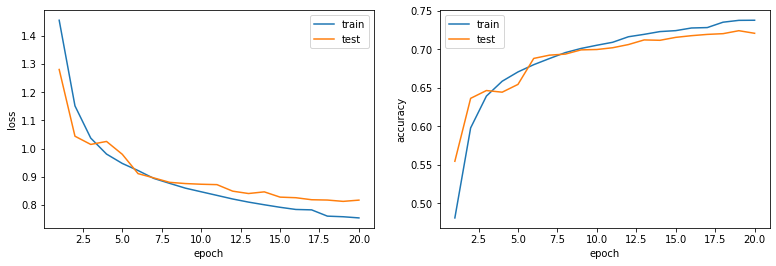

In [34]:
plot_losses(train_loss_log, val_loss_log, train_acc_log, val_acc_log)

**OneCycleLR**: сначала увеличивает изначальный `lr` до `max_lr`, после этого затухает его. Этот алгоритм был описан в статье Super-Convergence: [Very Fast Training of Neural Networks Using Large Learning Rates](https://arxiv.org/abs/1708.07120)

In [35]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.3, steps_per_epoch=len(train_loader), epochs=20)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4853981733322144, train acc: 0.4698069012797075
 val loss: 1.4077688815745901, val acc: 0.504188829787234

Epoch 1
 train loss: 1.184420988481267, train acc: 0.5812997846324439
 val loss: 1.1247954984928699, val acc: 0.6062056739279564

Epoch 2
 train loss: 1.0617739760897495, train acc: 0.6241022460639368
 val loss: 1.0292246552223856, val acc: 0.6404476952045521

Epoch 3
 train loss: 1.0005667652029007, train acc: 0.6505941499085923
 val loss: 0.9977345174931466, val acc: 0.6533244680851064

Epoch 4
 train loss: 0.9586618096998448, train acc: 0.6671658723838151
 val loss: 0.9514699816703797, val acc: 0.6668882978723404

Epoch 5
 train loss: 0.9215421102382583, train acc: 0.6789019652650823
 val loss: 0.9637741682377268, val acc: 0.6653812058428501

Epoch 6
 train loss: 0.8963785071259661, train acc: 0.6878060525252571
 val loss: 0.9288851040474913, val acc: 0.6782358156873824

Epoch 7
 train loss: 0.8764438816572674, train acc: 0.6950370527708553
 val loss: 0.9

In [36]:
test_loss, test_acc = test(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_acc}")

 test loss: 0.8197468933026502, test acc: 0.7215366242038217


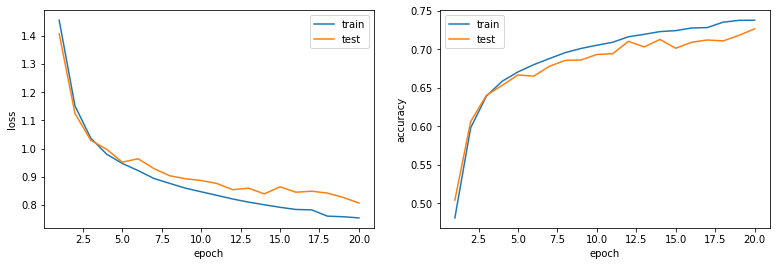

In [37]:
plot_losses(train_loss_log, val_loss_log, train_acc_log, val_acc_log)

**ConstantLR**: через `total_iters` эпох делит изначальный `lr` на `factor`. Можно изначально поставить большой `lr`, а после резко сильно его увеличть (зачем, вопрос хороший) 

In [38]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.9)
scheduler = optim.lr_scheduler.ConstantLR(optimizer, factor=0.5, total_iters=10)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4784469168626413, train acc: 0.470345553684932
 val loss: 1.2525086514493253, val acc: 0.5608599292471054

Epoch 1
 train loss: 1.1650872789527642, train acc: 0.5877309676933986
 val loss: 1.098090606040143, val acc: 0.6149822696726372

Epoch 2
 train loss: 1.0463021447715202, train acc: 0.6351119744058501
 val loss: 1.0090936653157498, val acc: 0.646875

Epoch 3
 train loss: 0.9837965447680388, train acc: 0.6601511491717978
 val loss: 1.06370711808509, val acc: 0.629033688027808

Epoch 4
 train loss: 0.9444579413429692, train acc: 0.6730706450926103
 val loss: 0.974638216799878, val acc: 0.6634086880278081

Epoch 5
 train loss: 0.9098936139556564, train acc: 0.6847088013314242
 val loss: 0.9334240390899333, val acc: 0.6750443263256803

Epoch 6
 train loss: 0.8827156470288307, train acc: 0.6953063790279507
 val loss: 0.9025205472682385, val acc: 0.6894946808510638

Epoch 7
 train loss: 0.8606280178866831, train acc: 0.7018926286392282
 val loss: 0.898657271963484

In [39]:
test_loss, test_acc = test(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_acc}")

 test loss: 0.9109137548003227, test acc: 0.68640525477707


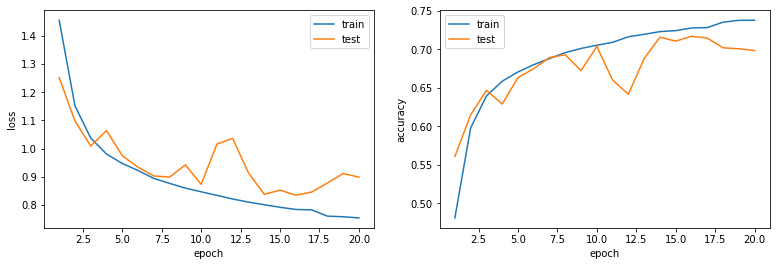

In [40]:
plot_losses(train_loss_log, val_loss_log, train_acc_log, val_acc_log)

Особо улучшить модели не получилось. Предполагаю, что более заметный эффект будет при обучении на более большом количестве эпох. Авторы статьи про `OneCycleLR` проводили эксперименте на `ResNet` и обучали модель на `Cifar-10` в течении более `100` эпох, в итоге получили качество свыше `85%`. (как нетрудно догадаться, мне очень понравилась идея `OneCycleLR`)

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

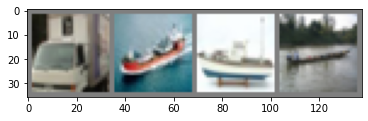

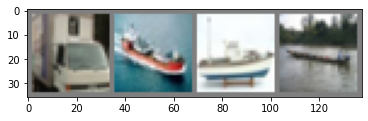

In [41]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [42]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.4810771362437192, train acc: 0.4711698550846721
 val loss: 1.2472078290391475, val acc: 0.5503989361702127

Epoch 1
 train loss: 1.172279482349835, train acc: 0.5909179942699412
 val loss: 1.0811692882091442, val acc: 0.6244902483960415

Epoch 2
 train loss: 1.0553716659763832, train acc: 0.6323289371059844
 val loss: 1.0548481119439956, val acc: 0.6370789007937655

Epoch 3
 train loss: 0.9993284103857316, train acc: 0.6563601789134512
 val loss: 0.9691995123599438, val acc: 0.6604831561129144

Epoch 4
 train loss: 0.9580200180493064, train acc: 0.666876142595978
 val loss: 0.9834351980939825, val acc: 0.6551640071767442

Epoch 5
 train loss: 0.9306070661849906, train acc: 0.678522460203502
 val loss: 0.9352275199078499, val acc: 0.6701462765957447

Epoch 6
 train loss: 0.9089861928435958, train acc: 0.6881406699499657
 val loss: 0.9670919494425997, val acc: 0.6654255319148936

Epoch 7
 t

Посчитайте точность на тестовой выборке:

In [43]:
test_loss, test_acc = test(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_acc}")

 test loss: 0.7913230306403652, test acc: 0.730593152866242


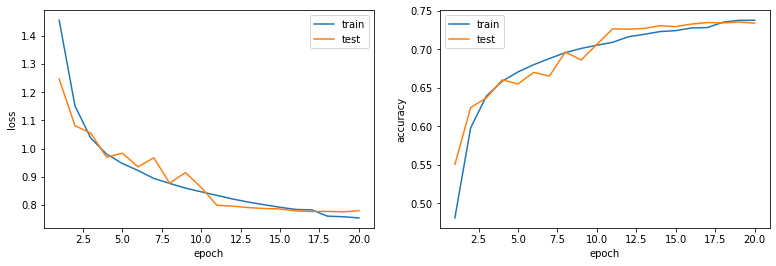

In [44]:
plot_losses(train_loss_log, val_loss_log, train_acc_log, val_acc_log)

**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

**RandomPerspective**: смотрим на изображение под другим углом

In [45]:
transform = transforms.Compose(
        [transforms.RandomPerspective(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.7041431654523889, train acc: 0.37987235575315065
 val loss: 1.5789009307293183, val acc: 0.4238253546522019

Epoch 1
 train loss: 1.4612506416641597, train acc: 0.47303473491773307
 val loss: 1.3986793568793763, val acc: 0.5004210993330529

Epoch 2
 train loss: 1.3265645164022497, train acc: 0.527532482386943
 val loss: 1.2656068893189125, val acc: 0.5582890071767441

Epoch 3
 train loss: 1.2387755395507465, train acc: 0.5617001828153565
 val loss: 1.1999063162093466, val acc: 0.5792553191489361

Epoch 4
 train loss: 1.1841479555126517, train acc: 0.5821852965154422
 val loss: 1.275794939284629, val acc: 0.5532801418862444

Epoch 5
 train loss: 1.153725899878542, train acc: 0.5949660486233518
 val loss: 1.1341390077103959, val acc: 0.5984929079705096

Epoch 6
 train loss: 1.127062108224663, train acc: 0.6032417080955924
 val loss: 1.1120661971416879, val acc: 0.6130762412192974

Epoch 7
 

In [46]:
test_loss, test_acc = test(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_acc}")

 test loss: 0.8700925635684068, test acc: 0.7018312101910829


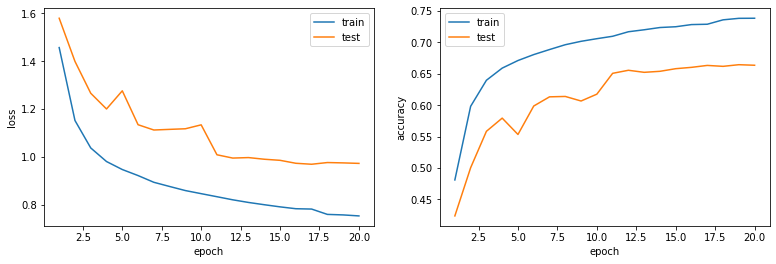

In [47]:
plot_losses(train_loss_log, val_loss_log, train_acc_log, val_acc_log)

**ColorJitter**: меняем яркость, контрастность, насыщенность изображения

In [48]:
transform = transforms.Compose(
        [transforms.ColorJitter(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.4968096597539005, train acc: 0.4658322995715865
 val loss: 1.30137687845433, val acc: 0.5329343972053934

Epoch 1
 train loss: 1.1808068208546263, train acc: 0.5829524680073126
 val loss: 1.0886941016988552, val acc: 0.6209219859001485

Epoch 2
 train loss: 1.055332658713653, train acc: 0.6327574105977576
 val loss: 1.038643324882426, val acc: 0.6463430851063829

Epoch 3
 train loss: 0.9918413379074669, train acc: 0.6551645338208409
 val loss: 0.9648724626987538, val acc: 0.6662898936170213

Epoch 4
 train loss: 0.9440408160525222, train acc: 0.6705528532565185
 val loss: 1.0306877024630283, val acc: 0.6446143617021277

Epoch 5
 train loss: 0.9132695497716803, train acc: 0.681403434363754
 val loss: 0.9590229442779054, val acc: 0.6658687944107867

Epoch 6
 train loss: 0.889636016251618, train acc: 0.6911481457610889
 val loss: 0.9289427381880739, val acc: 0.6755984042553191

Epoch 7
 trai

In [49]:
test_loss, test_acc = test(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_acc}")

 test loss: 0.8173760141536688, test acc: 0.7162619426751592


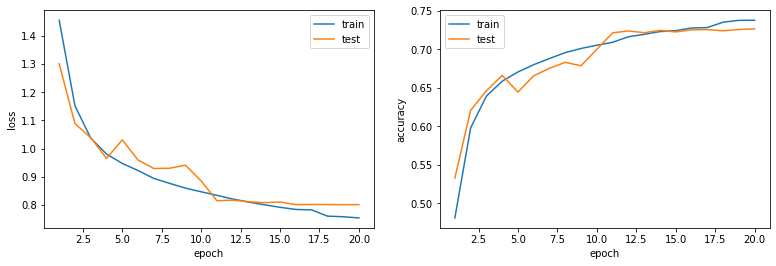

In [50]:
plot_losses(train_loss_log, val_loss_log, train_acc_log, val_acc_log)

**RandomHorizontalFlip && RandomPerspective && ColorJitter**:

In [52]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.RandomPerspective(),
         transforms.ColorJitter(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.707988517593858, train acc: 0.3762895012686414
 val loss: 1.5333905818614555, val acc: 0.44463652486496785

Epoch 1
 train loss: 1.4633101329507079, train acc: 0.4736631627056673
 val loss: 1.4074809870821365, val acc: 0.49776152486496783

Epoch 2
 train loss: 1.3206731076650253, train acc: 0.529438169281487
 val loss: 1.2517767145278607, val acc: 0.5575576241980208

Epoch 3
 train loss: 1.2429678807310909, train acc: 0.5606800079127771
 val loss: 1.2051992510227447, val acc: 0.5766622340425532

Epoch 4
 train loss: 1.1866809698519802, train acc: 0.5822138614148936
 val loss: 1.2047353886543437, val acc: 0.5697916667512123

Epoch 5
 train loss: 1.1554976327981548, train acc: 0.5936071755027422
 val loss: 1.1699070664162332, val acc: 0.5879432624958931

Epoch 6
 train loss: 1.119487194627033, train acc: 0.6073632149853262
 val loss: 1.1233793542740194, val acc: 0.6036347518575952

Epoch 7


In [53]:
test_loss, test_acc = test(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_acc}")

 test loss: 0.8495223374123786, test acc: 0.7072054140127388


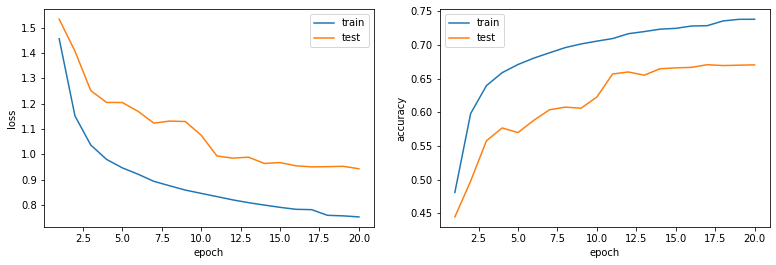

In [54]:
plot_losses(train_loss_log, val_loss_log, train_acc_log, val_acc_log)

## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [ ]:
# <your code here>